# **<span>PARTIE 1 : PHASE DE PREPARATION DES DONNEES </span>**

La base de données sur laquelle nous avons décidé de réaliser notre analyse est la BAAC (Bulletins d’Analyse des Accidents Corporels), produite par les forces de l’ordre françaises et dispoible sur le site https://www.data.gouv.fr. Cette base recense l’ensemble des accidents corporels de la circulation survenus sur le territoire français et fait référence dans les études de sécurité routière. Elle a été choisie pour la richesse des informations qu’elle contient, couvrant à la fois les caractéristiques de l’accident, le contexte routier, les véhicules impliqués et les profils des usagers. Mais aussi par sa structure détaillée avec des variables variées. On insère ci desosu le référentiel des variables de la BAAC qui nous a servi pour nettoyer nos tables et mesurer leur importance pour notre analyse 

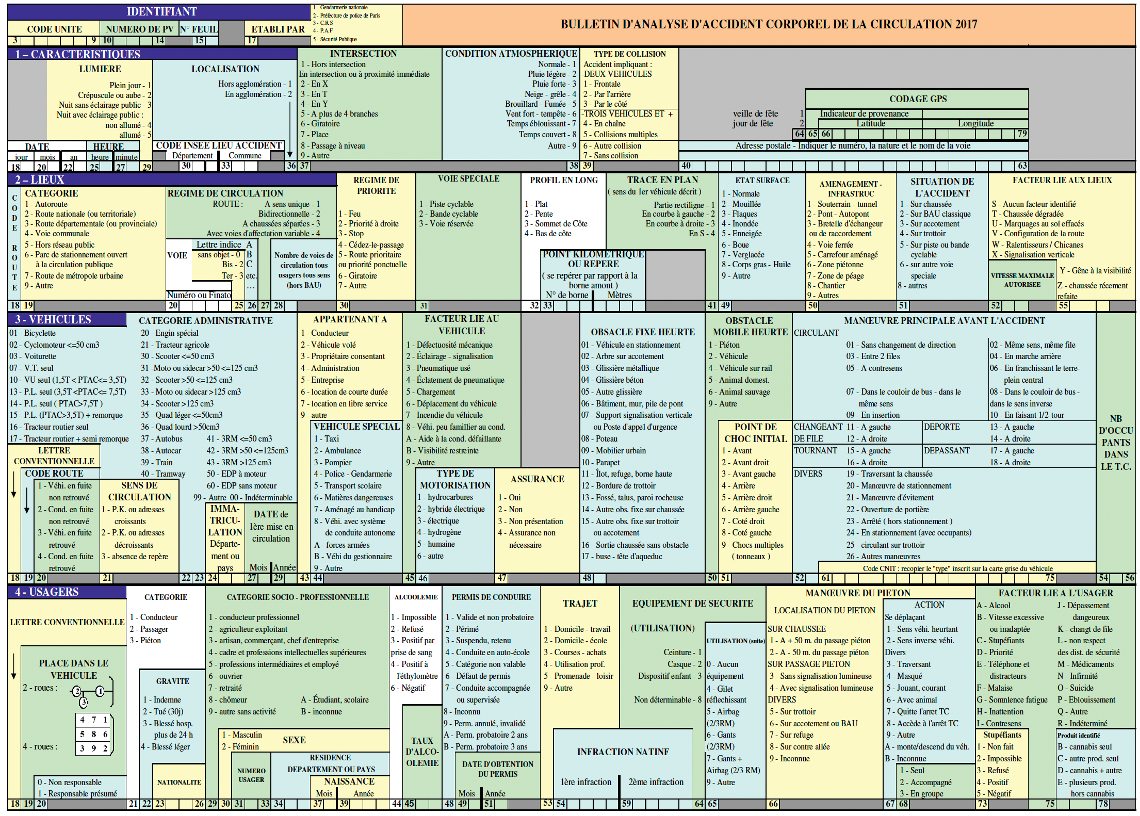

### Import des Bibliothèques 

In [ ]:
import pandas as pd
import numpy as np
import os
import re

# DIAGNOSTIC ET NETTOYAGE DES TABLES

* Chargement des données brutes : on charge les quatre bases de données 

In [67]:
caract_2023 = pd.read_csv("caract-2023.csv", sep=";")
lieux_2023 = pd.read_csv("lieux-2023.csv", sep=";")
usagers_2023 = pd.read_csv("usagers-2023.csv", sep=";")
vehicules_2023 = pd.read_csv("vehicules-2023.csv", sep=";")


/var/folders/pj/ynh4yj310jgfngg3gph293s80000gn/T/ipykernel_14648/361049351.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux_2023 = pd.read_csv("lieux-2023.csv", sep=";")


* DIAGNOSTIC CARACTÉRISTIQUES 2023

On effectue d'abord un rapide diagnostic pour identifier le nombre de lignes, de colonnes et les valeurs manquantes. On vérifie également la présence de doublons sur l’identifiant de l’accident. Un focus est réalisé sur certaines colonnes clés (jour, mois et année) afin de repérer d’éventuelles incohérences. Le format de l’heure et des coordonnées géographiques est vérifé de manière précise, par exemple les lignes où la date n'est pas comprise entre 1 et 31 etc, les mois invalides. Mais aussi que toutes les années soient bien 2023 et l'heure ne soit pas dans un mauvais format.

In [68]:
def diagnostic(df, year):
    print(f"\n=== DIAGNOSTIC CARACT {year} ===")
    print(f"Lignes : {df.shape[0]}")
    print(f"Colonnes : {df.shape[1]}")
    print("Valeurs manquantes :")
    print(df.isna().sum())
    print("Doublons Num_Acc :", df["Num_Acc"].duplicated().sum())

    print("Vérification jour/mois/an :")
    print("Jour hors plage :", df[(df['jour'] < 1) | (df['jour'] > 31)].shape[0])
    print("Mois hors plage :", df[(df['mois'] < 1) | (df['mois'] > 12)].shape[0])
    print("Année incohérente :", df[df['an'] != int(year)].shape[0], "\n")

    bad_hrmn = df[~df['hrmn'].astype(str).str.match(r'^\d{1,2}:\d{2}$', na=False)]
    print("Heures/minutes incorrectes :", len(bad_hrmn))

    print("lat avec virgule :", df['lat'].astype(str).str.contains(",").sum())
    print("long avec virgule :", df['long'].astype(str).str.contains(",").sum(), "\n")

diagnostic(caract_2023, "2023")



=== DIAGNOSTIC CARACT 2023 ===
Lignes : 54822
Colonnes : 15
Valeurs manquantes :
Num_Acc       0
jour          0
mois          0
an            0
hrmn          0
lum           0
dep           0
com           0
agg           0
int           0
atm           0
col           0
adr        1389
lat           0
long          0
dtype: int64
Doublons Num_Acc : 0
Vérification jour/mois/an :
Jour hors plage : 0
Mois hors plage : 0
Année incohérente : 0 

Heures/minutes incorrectes : 0
lat avec virgule : 54822
long avec virgule : 54822 



* NETTOYAGE CARACTÉRISTIQUES 2023

On crée ensuite une fonction pour nettoyer la table Caractéristiques.

On commence déjà par crée une copie de la table pour la nettoyer au cas où on souhaite modifier d'autres choses ou revenir en arrière sans modifier l'originale.

Les coordonnées géographiques (lat, long) sont corrigées en remplaçant les virgules par des points pour permettre leur conversion en variables numériques. Puis Les variables quantitatives(celles dans cols_num) sont ensuite converties en format numérique, les valeurs non valides étant transformées en NaN.

Les bornes officielles issues de la documentation BAAC sont utilisées pour identifier les valeurs incohérentes (par exemple des jours ou des mois hors plage, soit au dessus ou en dessous des bornes). Ces valeurs sont transforméees en valeurs manquantes afin de ne pas fausser l’analyse. 

Enfin, les variables codées sont converties en entiers lorsque cela est pertinent afin de garantir la cohérence des types de données.

In [ ]:
def nettoyer_caracteristiques(df):
    df = df.copy()

    # Correction lat / long (virgule -> point)
    df["lat"] = (df["lat"].astype(str).str.replace(",", ".", regex=False).astype(float))
    df["long"] = (df["long"].astype(str) .str.replace(",", ".", regex=False) .astype(float) )

    cols_num = ["jour", "mois", "an", "hrmn", "lum", "agg", "int", "atm", "col"]

    for col in cols_num:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Bornes issues de la documentation BAAC
    plage = {
        "jour": (1, 31),
        "mois": (1, 12),
        "an": (1900, 2100),
        "hrmn": (0, 2359),
        "lum": (1, 5),
        "agg": (1, 2),
        "int": (1, 8),
        "atm": (1, 9),
        "col": (1, 7)
    }

    for col, (minv, maxv) in plage.items():
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan

    # Colonnes à conserver en entiers
    cols_int = ["jour", "mois", "an", "hrmn", "lum", "agg", "int", "atm", "col"]

    for col in cols_int:
        df[col] = df[col].astype("Int64")

    return df

* DIAGNOSTIC LIEUX 2023

On commence par réaliser un diagnostic général de la table lieux afin d’observer sa structure, le type des variables et le nombre de lignes. On identifie ensuite les valeurs manquantes présentes dans chaque colonne afin d’évaluer leur importance pour notre future analyse. Enfin, on vérifie la présence de doublons sur l’identifiant de l’accident (Num_Acc) pour s’assurer de la cohérence des données.

In [70]:
def diagnostic_lieux(df, year):
    print(f"\n=== DIAGNOSTIC LIEUX {year} ===")
    print(df.info())
    print("Valeurs manquantes :")
    print(df.isna().sum())
    print("Doublons Num_Acc :", df["Num_Acc"].duplicated().sum())

diagnostic_lieux(lieux_2023, "2023")


=== DIAGNOSTIC LIEUX 2023 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70860 entries, 0 to 70859
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  70860 non-null  int64 
 1   catr     70860 non-null  int64 
 2   voie     58113 non-null  object
 3   v1       70860 non-null  int64 
 4   v2       5884 non-null   object
 5   circ     70860 non-null  int64 
 6   nbv      70860 non-null  object
 7   vosp     70860 non-null  int64 
 8   prof     70860 non-null  int64 
 9   pr       70860 non-null  object
 10  pr1      70860 non-null  object
 11  plan     70860 non-null  int64 
 12  lartpc   31 non-null     object
 13  larrout  70860 non-null  object
 14  surf     70860 non-null  int64 
 15  infra    70860 non-null  int64 
 16  situ     70860 non-null  int64 
 17  vma      70860 non-null  int64 
dtypes: int64(11), object(7)
memory usage: 9.7+ MB
None
Valeurs manquantes :
Num_Acc        0
catr           0
voie     

 * NETTOYAGE LIEUX 2023

On commence déjà par crée une copie de la table pour la nettoyer au cas où on souhaite modifier d'autres choses ou revenir en arrière sans modifier l'originale.

On commence par remplacer les champs vides ou contenant uniquement des espaces par des valeurs manquantes afin d’uniformiser le traitement des données absentes. Certaines variables sont ensuite converties en format numérique, les valeurs non valides étant transformées en NaN.

À partir des bornes définies dans la documentation officielle BAAC, on identifie les valeurs incohérentes pour plusieurs variables décrivant l’infrastructure et l’environnement de la route (catégorie de route, profil, surface, situation, vitesse maximale autorisée etc). 

Ces valeurs hors plage sont supprimées afin d’éviter toute erreur d’interprétation lors de l’analyse. Enfin, les variables codées sont converties en entiers pour garantir la cohérence des types de données et ne pas avoir de chiffres décimaux.

In [71]:
def nettoyer_lieux(df):
    df = df.copy()
    cols = ["voie", "v2", "nbv", "pr", "pr1", "lartpc", "larrout"]
    for col in cols:
        df[col] = df[col].replace({"": np.nan, " ": np.nan})

    for col in ["voie", "v2", "nbv", "pr", "pr1", "larrout"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    # Bornes issues de la documentation BAAC
    plage = {
        "catr": (1, 9),
        "circ": (1, 9),
        "prof": (0, 9),
        "plan": (1, 9),
        "surf": (1, 9),
        "infra": (0, 9),
        "situ": (1, 8),
        "vma": (0, 150)
    }

    for col, (minv, maxv) in plage.items():
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan

    cols_int = [
        "catr", "circ", "nbv", "prof", "surf", "infra", "situ", "vma"
    ]

    for col in cols_int:
        df[col] = df[col].astype("Int64")

    return df

lieux_2023_clean = nettoyer_lieux(lieux_2023)

* DIAGNOSTIC USAGERS 2023

On réalise un diagnostic général de la table usagers afin d’observer sa structure et les types de variables. 

On identifie ensuite les valeurs manquantes présentes dans chaque colonne pour évaluer leur importance. 

Enfin, on vérifie la présence de doublons sur la combinaison (Num_Acc, id_usager), qui correspond à l’identifiant unique d’un usager dans un accident, afin de s’assurer de la cohérence des données.

In [72]:
def diagnostic_usagers(df, year):
    print(f"\n=== DIAGNOSTIC USAGERS {year} ===\n")
    print(df.info())
    print("\nValeurs manquantes :\n", df.isna().sum())
    print("Doublons Num_Acc + id_usager :", df.duplicated(subset=["Num_Acc", "id_usager"]).sum(), "\n")

diagnostic_usagers(usagers_2023, "2023")


=== DIAGNOSTIC USAGERS 2023 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125789 entries, 0 to 125788
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      125789 non-null  int64  
 1   id_usager    125789 non-null  object 
 2   id_vehicule  125789 non-null  object 
 3   num_veh      125789 non-null  object 
 4   place        125789 non-null  int64  
 5   catu         125789 non-null  int64  
 6   grav         125789 non-null  int64  
 7   sexe         125789 non-null  int64  
 8   an_nais      123191 non-null  float64
 9   trajet       125789 non-null  int64  
 10  secu1        125789 non-null  int64  
 11  secu2        125789 non-null  int64  
 12  secu3        125789 non-null  int64  
 13  locp         125789 non-null  int64  
 14  actp         125789 non-null  object 
 15  etatp        125789 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 15.4+ MB
None

Valeurs man

* NETTOYAGE USAGERS 2023

On commence par harmoniser les identifiants des usagers et des véhicules en supprimant les espaces et caractères invisibles, afin d’éviter des erreurs lors des jointures entre les tables. 

On identifie ensuite certaines valeurs aberrantes (comme des valeurs impossibles hors des bornes etc) et on choisit de les remplacer par des valeurs manquantes pour ne pas fausser l’analyse.

À partir des bornes définies dans la documentation officielle BAAC, on vérifie la cohérence des variables codées (sexe, gravité, trajet, localisation et activité du piéton, place dans le véhicule). 

 Enfin, les principales variables que l'on garde dans le CSV nettoyé sont converties en entiers afin de garantir la cohérence des types de données.

In [ ]:
def nettoyer_usagers(df):
    df = df.copy()
    df["id_vehicule"] = df["id_vehicule"].astype(str).str.replace(" ", "").str.replace("\xa0", "")
    df["id_usager"] = df["id_usager"].astype(str).str.replace(" ", "").str.replace("\xa0", "")

    aberrants = [-1, 0, 99, 999, "99", "0"]

    for col in df.columns:
        df[col] = df[col].replace(aberrants, np.nan)

    # Bornes issues de la documentation BAAC
    plages = {
        "sexe": (1, 2),
        "grav": (1, 4),
        "trajet": (1, 9),
        "locp": (1, 9),
        "actp": (1, 13),
        "place": (1, 9)
    }

    for col, (minv, maxv) in plages.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan
    
    cols_int = [
        "Num_Acc","id_usager","place","catu","grav","sexe","an_nais","trajet"
    ]

    for col in cols_int:
        df[col] = df[col].astype("Int64")
    
    return df

usagers_2023_clean = nettoyer_usagers(usagers_2023)

* DIAGNOSTIC VEHICULES 2023

On réalise un diagnostic général de la table véhicules afin d’observer sa structure et les types de variables. On vérifie ensuite la présence de doublons sur la combinaison (Num_Acc, id_vehicule), qui correspond à l’identifiant unique d’un véhicule impliqué dans un accident, afin de s’assurer de la cohérence des données.

In [74]:
def diagnostic_vehicules(df, year):
    print(f"\n=== DIAGNOSTIC VEHICULES {year} ===\n")
    print(df.info())
    print("Doublons Num_Acc + id_vehicule :", df.duplicated(subset=["Num_Acc", "id_vehicule"]).sum())

diagnostic_vehicules(vehicules_2023, "2023")


=== DIAGNOSTIC VEHICULES 2023 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93585 entries, 0 to 93584
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Num_Acc      93585 non-null  int64  
 1   id_vehicule  93585 non-null  object 
 2   num_veh      93585 non-null  object 
 3   senc         93585 non-null  int64  
 4   catv         93585 non-null  int64  
 5   obs          93585 non-null  int64  
 6   obsm         93585 non-null  int64  
 7   choc         93585 non-null  int64  
 8   manv         93585 non-null  int64  
 9   motor        93585 non-null  int64  
 10  occutc       838 non-null    float64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.9+ MB
None
Doublons Num_Acc + id_vehicule : 0


On commence par harmoniser l’identifiant du véhicule en supprimant les espaces et caractères invisibles afin d’éviter des erreurs lors des jointures plus tard puisque c'est la seule variable commune aux quatre tables. 

Certaines valeurs aberrantes ou génériques sont ensuite remplacées par des valeurs manquantes. Le code 99 est conservé pour la variable catv, car il correspond à la catégorie « autres » dans la documentation BAAC.

À partir des bornes définies dans la documentation officielle BAAC, on contrôle la cohérence des variables. Les valeurs hors plage sont considérées comme incohérentes et supprimées. 

Enfin, les variables codées sont converties en entiers afin de garantir la cohérence des types de données.

In [ ]:
def nettoyer_vehicules(df):
    df = df.copy()
    df["id_vehicule"] = df["id_vehicule"].astype(str).str.replace(" ", "").str.replace("\xa0", "")

    aberrants = [-1, 0, 999, "0"] # ici pas de 99 car la catégorie autres de catv va jusqu'à 99

    for col in df.columns:
        df[col] = df[col].replace(aberrants, np.nan)

    # Bornes issues de la documentation BAAC
    plages = {
        "senc": (1, 3),
        "catv": (1, 99),
        "choc": (1, 9),
        "manv": (1, 26),
        "motor": (1, 6)
    }

    for col, (minv, maxv) in plages.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan

    cols_int = [
        "senc", "catv", "choc", "manv", "motor"
    ]

    for col in cols_int:
        df[col] = df[col].astype("Int64")
    return df

vehicules_2023_clean = nettoyer_vehicules(vehicules_2023)

# SUPPRESSION COLONNES INUTILES

Ici on s'occupe de supprimer les colonnes jugées inutiles dans les CSV afin de faciliter leur utilisation pour notre analyse plus tard.

### TABLE CARACTERISTIQUES

Nous avons choisi de supprimer certaines variables de la table caractéristiques lorsqu’elles n’étaient pas pertinentes pour l’analyse ou redondantes avec d’autres informations. Les variables dep et com, qui identifient la localisation (départements et communes), n’ont pas été conservées car l’analyse ne porte pas sur une échelle territoriale fine. 

La variable adr a été supprimée car elle contient principalement des informations textuelles peu exploitables (par exemple on passe de A15 à Rue Professeur Beauvisage ou encore FELIX EBOUE(ROCADE), les valeurs sont trop différentes et ce n'est pas possible de les généraliser) et il y a aussi un grand nombre de valeurs manquantes. 

Enfin, la variable int a été retirée car elle n’apportait pas d’informations supplémentaires utiles dans le cadre de l’analyse menée, elle explique le type d'intersection (Hors intersection, Intersection en X, Intersection en T...).

In [76]:
cols_drop_caract = [
    "dep", "com", "int",   
    "adr"                          
]
caract_2023.drop(columns=cols_drop_caract, inplace=True, errors="ignore")

### TABLE LIEUX 

Certaines variables de la table lieux ont été supprimées lorsqu’elles étaient peu renseignées ou peu pertinentes pour l’analyse. 

Les variables voie (même problème que adr au dessus), larrout, v2, lartpc, présentent un nombre important de valeurs manquantes ou correspondent à des informations très spécifiques difficilement exploitables, quand à  pr et pr1 elles représentent un point de repère géographique, elles ne seront pas pertinentes pour nos analyses, les CSV ne doivent pas être trop lourd aussi pour que l'aplication streamlit puisse bien fonctionner. 

La variable v1, correspondant à un identifiant technique (type de numéro de voie), a également été supprimée car elle n’apporte pas d’information analytique utile et présente le plus souvent des -1 ou 0 qui ne correspondent à aucune information. 

Enfin, la variable plan (qui représente le rayon de courbure ou l'alignement de la route) a été retirée afin de simplifier le jeu de données et de se concentrer sur les caractéristiques principales de l’infrastructure.

In [77]:
cols_drop_lieux = [
    "voie",      
    "v1",        
    "larrout",   
    "v2",
    "lartpc",
    "plan",
    "pr","pr1" 
     
]
lieux_2023_clean.drop(columns=cols_drop_lieux, inplace=True, errors="ignore")


* TABLE USAGERS

Certaines variables de la table usagers ont été supprimées lorsqu’elles n’étaient pas pertinentes pour l’analyse ou redondantes avec d’autres informations. 

La variable num_veh, utilisée uniquement comme identifiant technique, a été retirée car l’identification du véhicule est déjà assurée par id_vehicule. 

Les variables locp, actp et etatp, relatives au comportement des piétons, ont été supprimées car l’analyse ne se concentre pas spécifiquement sur ce type d’usagers, mais surtout car elles étaient aussi cosntiutés de valeurs nuls comme -1 qui se rapporte à aucune information. 

On supprime aussi la variable trajet, qui comporte 45 000 valeurs manquantes sur 125 000 environ et qui ne sous servira pas pour notre analyse.

Enfin, les variables secu1, secu2 et secu3, décrivant les équipements de sécurité, ont été retirées car elles comportaient beaucoup de valeurs -1 donc non identifiées et afin de simplifier le jeu de données, ces informations ne seront pas exploitées dans les analyses.

In [ ]:
cols_drop_usagers = [
    "num_veh",
    "trajet",
    "locp",
    "actp",
    "etatp",
    "secu1", "secu2", "secu3"  
]
usagers_2023_clean.drop(columns=cols_drop_usagers, inplace=True, errors="ignore")


* TABLE VEHICULES

La variable num_veh, utilisée uniquement comme identifiant interne, a été retirée, l’identification du véhicule étant déjà assurée par la variable id_vehicule.

Les variables motor, obs et obsm (type de véhicule, obstacle heurté fixe et mobile) n’ont pas été retenues pour l’analyse, car elles sont composées en grande partie de la valeur 0, qui ne correspond à aucune information exploitable dans la nomenclature BAAC, ou de valeurs manquantes.

De même, les variables manv (manœuvre principale) et occutc, qui ne comporte que 828 valeurs non nulles, ont été supprimées afin de simplifier le jeu de données. Ces informations ne seront pas mobilisées dans les analyses menées.

In [ ]:
cols_drop_veh = [
    "motor",
    "num_veh",
    "obs",
    "obsm",
    "manv",
    "occutc"     
]
vehicules_2023_clean.drop(columns=cols_drop_veh, inplace=True, errors="ignore")


# CREATION DE VARIABLES 

### PREMIERE VARIABLE : Période de la journée 

Une nouvelle variable période est créée à partir de l’heure de l’accident (hrmn). L’objectif est de regrouper les accidents selon de grandes périodes de la journée (nuit, matin, après-midi, soir) afin de faciliter l’analyse temporelle et de comparer les dynamiques d’accidents selon le moment de la journée.

In [80]:
def periode_journee(h):
    if "00:00" <= h < "06:00":
        return "Nuit"
    elif "06:00" <= h < "12:00":
        return "Matin"
    elif "12:00" <= h < "18:00":
        return "Après-midi"
    else:
        return "Soir"

caract_2023["periode"] = caract_2023["hrmn"].apply(periode_journee)

### DEUXIEME VARIABLE : Niveau de gravité de l'accident 

Une variable grav_3_niveaux est créée à partir de la variable grav afin de regrouper les niveaux de gravité en trois catégories principales : indemne, blessé hospitalisé et tué (on a décidé de regrouper indemne et blessé léger (1 et 4, cf bulletin d'analyse de la BAAC) pour créer la catégorie indemne). Ce regroupement permet de simplifier l’analyse de la gravité des accidents tout en conservant les informations essentielles pour l’étude.

In [81]:
def gravite_3_niveaux(grav):
    if pd.isna(grav):
        return None
    elif grav == 2:
        return "Tué"
    elif grav == 3:
        return "Blessé hospitalisé"
    elif grav in [1, 4]:
        return "Indemne"
    else:
        return None
usagers_2023_clean["grav_3_niveaux"] = usagers_2023_clean["grav"].apply(gravite_3_niveaux)

### TROISIEME VARIABLE : La tranche d'âge

La variable âge est calculée à partir de l’année de naissance (an_nais) afin d’estimer l’âge des usagers au moment de l’accident. Une variable tranche_age est ensuite créée pour regrouper les usagers dans des classes d’âge. Cette catégorisation permet de faciliter l’analyse des profils d’usagers impliqués dans les accidents.

In [82]:
usagers_2023_clean["age"] = 2023 - usagers_2023_clean["an_nais"]

def tranche_age(a):
    if pd.isna(a): 
        return None
    elif a < 18:
        return "Mineur"
    elif a < 25:
        return "18–24"
    elif a < 40:
        return "25–39"
    elif a < 60:
        return "40–59"
    else:
        return "60+"

usagers_2023_clean["tranche_age"] = usagers_2023_clean["age"].apply(tranche_age)

### QUATRIEME VARIABLE : La zone de l'accident

La variable agg, issue de la table caractéristiques, est d’abord fusionnée avec la table lieux afin de disposer de l’information sur le contexte urbain ou rural de l’accident. Une nouvelle variable zone_detaillee est ensuite créée en combinant la catégorie de route (catr), la vitesse maximale autorisée (vma) et le type de zone (agg). Cette variable permet de distinguer différents contextes de circulation (zone urbaine dense, zone rurale, autoroute ou voie rapide) et facilite l’analyse des accidents selon l’environnement.

In [ ]:
# Fusion de la variable agg (table caractéristiques) dans la table lieux
lieux_2023_clean = lieux_2023_clean.merge(
    caract_2023[["Num_Acc", "agg"]],
    on="Num_Acc",
    how="left"
)

def zone_detaillee(agg, catr, vma):
    if pd.isna(agg) or pd.isna(vma):
        return None
    elif catr == 1 or vma >= 90:
        return "Autoroute"
    elif agg == 2 and vma <= 50:
        return "Zone urbaine dense"
    elif agg == 1 and vma <= 80:
        return "Zone rurale"
    else:
        return "Autre"

lieux_2023_clean["zone_detaillee"] = lieux_2023_clean.apply(
    lambda x: zone_detaillee(x["agg"], x["catr"], x["vma"]),
    axis=1
)

### CINQUIEME VARIABLE : Le niveau de vitesse 

Une variable niveau_vitesse est créée à partir de la vitesse maximale autorisée (vma) afin de regrouper les limitations de vitesse en trois niveaux (faible, moyenne, élevée). Cette catégorisation permet de simplifier l’analyse et de comparer les accidents selon le niveau de vitesse des usagers au moment de l'accident.

In [ ]:
def niveau_vitesse(v):
    if pd.isna(v):
        return None
    elif v <= 30:
        return "Faible"
    elif v <= 70:
        return "Moyenne"
    else:
        return "Élevée"
lieux_2023_clean["niveau_vitesse"] = lieux_2023_clean["vma"].apply(niveau_vitesse)

### EXPORT FINAL 2023 

In [85]:
os.makedirs("clean", exist_ok=True)

caract_2023.to_csv("clean/caract_2023_clean.csv", index=False)
lieux_2023_clean.to_csv("clean/lieux_2023_clean.csv", index=False)
usagers_2023_clean.to_csv("clean/usagers_2023_clean.csv", index=False)
vehicules_2023_clean.to_csv("clean/vehicules_2023_clean.csv", index=False)

# MERGE FINAL 2023
df_2023 = (
    caract_2023
        .merge(lieux_2023_clean, on="Num_Acc", how="left")
        .merge(vehicules_2023_clean, on="Num_Acc", how="left")
        .merge(usagers_2023_clean, on=["Num_Acc", "id_vehicule"], how="left")
)

df_2023.to_csv("clean/final_2023.csv", index=False)

In [ ]:
print("Informations finales après nettoyage :\n")
caract_2023.info()
caract_2023.isna().mean()

lieux_2023_clean.info()
lieux_2023_clean.isna().mean()

usagers_2023_clean.info()
usagers_2023_clean.isna().mean()

vehicules_2023_clean.info()
vehicules_2023_clean.isna().mean()

# **<span>PARTIE 2 : TEXT MINING </span>**

Import des Bibliothèques 

In [1]:
from unidecode import unidecode 
import re
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

1. **Collecte des données**  
Récupération du texte à analyser, ici c'est un article du monde concernant la sécurité routière

In [2]:
with open("article.txt", "r", encoding="utf-8") as f: 
    texte = f.read() 
print("Aperçu du texte :") 
print(texte[:500]) # pour vérifier que le texte se charge bien

Aperçu du texte :

Sécurité routière : en 2023, le nombre de morts sur les routes de France en baisse par rapport à 2022
Malgré la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport à 2019, année de référence pour la Sécurité routière.
Le Monde avec AFP
Publié le 01 février 2024 à 12h22 
Temps de Lecture 1 min.

Un total de 3 170 personnes sont mortes sur les routes de France métropolitaine en 2023, soit 3 % de moins qu’en 2022, a annoncé, jeudi 1er février, la Sécurité 


On affiche le nombre de caractères et le nombre de mots de l'article

In [ ]:
print(f"Le document contient {len(texte)} caractères.\n")
liste_mots = texte.split()   # Sépare les mots en fonction de l’espace
print(f"Le document contient {len(liste_mots)} mots.")

Le document contient 2410 caractères.

Le document contient 421 mots.


2. **Prétraitement du texte**  
On commence par le Nettoyage avec : 
- La mise en minuscule (pour uniformiser). 
- La suppression des caractères spéciaux (ponctuation, chiffres inutiles).   
- La suppression des espaces superflus.  
- La correction orthographique.   
- La suppression des stop words 


On commence par mettre tout le texte en minuscule

In [4]:
texte_min = texte.lower()
print(texte_min)


sécurité routière : en 2023, le nombre de morts sur les routes de france en baisse par rapport à 2022
malgré la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport à 2019, année de référence pour la sécurité routière.
le monde avec afp
publié le 01 février 2024 à 12h22 
temps de lecture 1 min.

un total de 3 170 personnes sont mortes sur les routes de france métropolitaine en 2023, soit 3 % de moins qu’en 2022, a annoncé, jeudi 1er février, la sécurité routière.
l’année écoulée a été marquée par la baisse du nombre de morts dans toutes les catégories d’usagers de la route, à l’exception des utilisateurs d’engins de déplacements personnels motorisés (edpm) comme les trottinettes, avec 42 tués, en hausse de 7 % par rapport à 2022.

la déléguée interministérielle à la sécurité routière, florence guillaume, a insisté sur les « chiffres encourageants » de l’observatoire national interministériel de la sécurité routière (onisr), présentées à la pres

On enlève les accents du texte

In [5]:
texte_sans_accents = unidecode(texte_min)
print(texte_sans_accents)



securite routiere : en 2023, le nombre de morts sur les routes de france en baisse par rapport a 2022
malgre la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport a 2019, annee de reference pour la securite routiere.
le monde avec afp
publie le 01 fevrier 2024 a 12h22 
temps de lecture 1 min.

un total de 3 170 personnes sont mortes sur les routes de france metropolitaine en 2023, soit 3 % de moins qu'en 2022, a annonce, jeudi 1er fevrier, la securite routiere.
l'annee ecoulee a ete marquee par la baisse du nombre de morts dans toutes les categories d'usagers de la route, a l'exception des utilisateurs d'engins de deplacements personnels motorises (edpm) comme les trottinettes, avec 42 tues, en hausse de 7 % par rapport a 2022.

la deleguee interministerielle a la securite routiere, florence guillaume, a insiste sur les << chiffres encourageants >> de l'observatoire national interministeriel de la securite routiere (onisr), presentees a la pr

- On supprime les nombres présents dans le texte, notamment les années.

In [6]:

texte_nettoye = re.sub(r'[0-9]{4}', 'annee', texte_sans_accents) 
texte_nettoye = re.sub(r'[0-9]+\s*%', 'pourcentage', texte_nettoye)
texte_nettoye = re.sub(r'[0-9]+', 'nombre', texte_nettoye)
print(texte_nettoye)



securite routiere : en annee, le nombre de morts sur les routes de france en baisse par rapport a annee
malgre la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de pourcentage par rapport a annee, annee de reference pour la securite routiere.
le monde avec afp
publie le nombre fevrier annee a nombrehnombre 
temps de lecture nombre min.

un total de nombre nombre personnes sont mortes sur les routes de france metropolitaine en annee, soit pourcentage de moins qu'en annee, a annonce, jeudi nombreer fevrier, la securite routiere.
l'annee ecoulee a ete marquee par la baisse du nombre de morts dans toutes les categories d'usagers de la route, a l'exception des utilisateurs d'engins de deplacements personnels motorises (edpm) comme les trottinettes, avec nombre tues, en hausse de pourcentage par rapport a annee.

la deleguee interministerielle a la securite routiere, florence guillaume, a insiste sur les << chiffres encourageants >> de l'observatoire national int

In [7]:
texte_nettoye_2 = re.sub(r"[^a-z]+", ' ', texte_nettoye) 
print(texte_nettoye_2)

 securite routiere en annee le nombre de morts sur les routes de france en baisse par rapport a annee malgre la diminution du nombre de morts sur les autoroutes ce chiffre est en hausse de pourcentage par rapport a annee annee de reference pour la securite routiere le monde avec afp publie le nombre fevrier annee a nombrehnombre temps de lecture nombre min un total de nombre nombre personnes sont mortes sur les routes de france metropolitaine en annee soit pourcentage de moins qu en annee a annonce jeudi nombreer fevrier la securite routiere l annee ecoulee a ete marquee par la baisse du nombre de morts dans toutes les categories d usagers de la route a l exception des utilisateurs d engins de deplacements personnels motorises edpm comme les trottinettes avec nombre tues en hausse de pourcentage par rapport a annee la deleguee interministerielle a la securite routiere florence guillaume a insiste sur les chiffres encourageants de l observatoire national interministeriel de la securite 

- On télécharge la liste de stopword et on récupère la liste française

In [9]:

nltk.download('stopwords')
stopWords = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibouchichenelina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- On découpe le texte nettoyé en mots et on supprime les stopwords

In [10]:
liste_mots = texte_nettoye.split()
liste_mots = [word for word in liste_mots if word not in stopWords]

print(liste_mots)

['securite', 'routiere', ':', 'annee,', 'nombre', 'morts', 'routes', 'france', 'baisse', 'rapport', 'a', 'annee', 'malgre', 'diminution', 'nombre', 'morts', 'autoroutes,', 'chiffre', 'hausse', 'pourcentage', 'rapport', 'a', 'annee,', 'annee', 'reference', 'securite', 'routiere.', 'monde', 'afp', 'publie', 'nombre', 'fevrier', 'annee', 'a', 'nombrehnombre', 'temps', 'lecture', 'nombre', 'min.', 'total', 'nombre', 'nombre', 'personnes', 'mortes', 'routes', 'france', 'metropolitaine', 'annee,', 'pourcentage', 'moins', "qu'en", 'annee,', 'a', 'annonce,', 'jeudi', 'nombreer', 'fevrier,', 'securite', 'routiere.', "l'annee", 'ecoulee', 'a', 'ete', 'marquee', 'baisse', 'nombre', 'morts', 'toutes', 'categories', "d'usagers", 'route,', 'a', "l'exception", 'utilisateurs', "d'engins", 'deplacements', 'personnels', 'motorises', '(edpm)', 'comme', 'trottinettes,', 'nombre', 'tues,', 'hausse', 'pourcentage', 'rapport', 'a', 'annee.', 'deleguee', 'interministerielle', 'a', 'securite', 'routiere,', 'fl

* Ensuite la Tokenisation :   
On découper le texte en unités de base : mots, n-grammes, ou phrases.
Exemple : "Je mange une pomme." → ["Je", "mange", "une", "pomme"]  

In [11]:
liste_mots = texte.split()

print(f"L'article contient {len(liste_mots)} mots.")
print(f"Les 20 premiers mots : {liste_mots[:20]} \n")



L'article contient 421 mots.
Les 20 premiers mots : ['Sécurité', 'routière', ':', 'en', '2023,', 'le', 'nombre', 'de', 'morts', 'sur', 'les', 'routes', 'de', 'France', 'en', 'baisse', 'par', 'rapport', 'à', '2022'] 



* Puis la Normalisation :   
Lemmatisation : ramener un mot à sa forme de base (ex : "mangé" → "manger").  
Stemming : réduire un mot à sa racine (ex : "mangé" → "mang").  
Ces deux étapes permettent de regrouper différentes formes d’un mot.

In [12]:
# Télécharger la liste des stopwords (une seule fois)
nltk.download('stopwords')

# Récupérer la liste française
stopWords = stopwords.words('french')

print(len(stopWords))
print(stopWords[:20])  # pour voir un aperçu

157
['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibouchichenelina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Télécharger la liste des stopwords (une seule fois)
nltk.download('stopwords')

# Récupérer la liste française
stopWords = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibouchichenelina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# creation du stemmer
stemmer = SnowballStemmer("french")

In [15]:
# Création d'une fonction pour supprimer les sw
def no_stop_word(string, stopWords):

    """
    Supprime les stop words d'un texte.

    Paramètres
    ----------

    string : chaine de caractère.

    stopWords : liste de mots à exclure. 
    
    ----------
    Sortie : string sans stopWords
    """
    string = ' '.join([word for word in string.split() if word not in stopWords])
    return string
    
    

# Création d'une fonction pour stemmatiser chaque mot d'un text 
def stemmatise_text(text, stemmer):

    """
    Stemmatise un texte : Ramène les mots d'un texte à leur racine (peut créer des mots qui n'existe pas).

    Paramètres
    ----------

    text : Chaine de caractères.

    stemmer : Stemmer de NLTK.
    
    ----------
    Sortie : string qui contient la forme stemmatisée des mots
    """
    string = ' '.join([stemmer.stem(word) for word in text.split()])
    return string
    


In [16]:
texte_stemmatise = stemmatise_text(texte, stemmer)

print("Aperçu du texte stemmatisé :")
print(texte_stemmatise[:500])


Aperçu du texte stemmatisé :
sécur routi : en 2023, le nombr de mort sur le rout de franc en baiss par rapport à 2022 malgr la diminu du nombr de mort sur le autoroutes, ce chiffr est en hauss de 4 % par rapport à 2019, anné de référent pour la sécur routière. le mond avec afp publi le 01 févri 2024 à 12h22 temp de lectur 1 min. un total de 3 170 person sont mort sur le rout de franc métropolitain en 2023, soit 3 % de moin qu’en 2022, a annonce, jeud 1er février, la sécur routière. l’ann écoul a été marqu par la baiss du no


3. **Vectorisation**    
Transformation du texte en vecteurs numériques (Bag of Words, TF-IDF, embeddings).

In [17]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from collections import defaultdict

BAG OF WORD

In [18]:
texte_final = texte_stemmatise
corpus = [texte_final]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.toarray())
print(vectorizer.get_feature_names_out())

[[ 1  1  1  1  1  1  1  1  1  1  1  2  1  1  4  7  1  2  1  1  1  1  1  1
   1  1  1  1  1  2  3  1  3  1  1  1  1  1  1  2  4  7  1  1  1  2  1  1
   4  1  1  1  1  1  2  2 35  1  1  2  1  3  2  1  2  1  1 17  1  1  2  1
   3  3  1  1  2  1  1  1  3  1  1  1  2  1 16 19  1  1  1  2  1  1  1  1
   7  2  1  2  1  1  2  2  4  1  1  1  1  2  1  8  1  1  2  1  1  1  1  1
   5  1  2  1  1  1  2  1  7  1  1  1  5  1  7  3  1  2  1  1  1  2  2  1
   8  1  7  1  1  1  1  1  1  3  1  1  2  4  1  2  1  1  2  1  3]]
['000' '01' '016' '10' '11' '12h22' '170' '18' '19' '1er' '200' '2019'
 '2020' '2021' '2022' '2023' '2024' '226' '232' '273' '40' '42' '440'
 '525' '707' '881' 'abon' 'affilée' 'afp' 'agglomer' 'ann' 'annonce'
 'anné' 'articl' 'assembl' 'au' 'auss' 'automob' 'autorout' 'autoroutes'
 'avec' 'baiss' 'barr' 'bobigny' 'catégor' 'ce' 'centr' 'chez' 'chiffr'
 'cmpr' 'comm' 'constat' 'covid' 'création' 'cyclist' 'dan' 'de' 'del'
 'deux' 'diminu' 'discut' 'du' 'déces' 'délégu' 'déplac' 'détai

Les N-grammes 

In [19]:

# 1er document du corpus
print(f"Notre 1er document : {corpus[0]} \n")

# Liste des bigrammes
print(f"La liste des bigrammes présents dans le 1er document : {list(nltk.bigrams(corpus[0].split()))}")


Notre 1er document : sécur routi : en 2023, le nombr de mort sur le rout de franc en baiss par rapport à 2022 malgr la diminu du nombr de mort sur le autoroutes, ce chiffr est en hauss de 4 % par rapport à 2019, anné de référent pour la sécur routière. le mond avec afp publi le 01 févri 2024 à 12h22 temp de lectur 1 min. un total de 3 170 person sont mort sur le rout de franc métropolitain en 2023, soit 3 % de moin qu’en 2022, a annonce, jeud 1er février, la sécur routière. l’ann écoul a été marqu par la baiss du nombr de mort dan tout le catégor d’usager de la route, à l’except de utilis d’engin de déplac personnel motoris (edpm) comm le trottinettes, avec 42 tues, en hauss de 7 % par rapport à 2022. la délégu interministériel à la sécur routière, florenc guillaume, a insist sur le « chiffr encourag » de l’observatoir national interministériel de la sécur routi (onisr), présent à la press au centr de médecin physiqu et de réadapt de bobigny (cmpr). lir auss | articl réserv à nos abon 

La représentation TF-IDF

In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.toarray())


[[0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.01830323 0.01830323 0.07321294 0.12812264 0.01830323 0.03660647
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.0549097  0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.03660647 0.07321294 0.12812264
  0.01830323 0.01830323 0.01830323 0.03660647 0.01830323 0.01830323
  0.07321294 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.03660647 0.03660647 0.64061319 0.01830323 0.01830323 0.03660647
  0.01830323 0.0549097  0.03660647 0.01830323 0.03660647 0.01830323
  0.01830323 0.31115498 0.01830323 0.01830323 0.03660647 0.01830323
  0.0549097  0.0549097  0.01830323 0.01830323 0.03660647 0.01830323
  0.01830323 0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.03660647 0.01830323 0.29285174 0.34776145 0.

In [21]:
print(vectorizer.get_feature_names_out())

['000' '01' '016' '10' '11' '12h22' '170' '18' '19' '1er' '200' '2019'
 '2020' '2021' '2022' '2023' '2024' '226' '232' '273' '40' '42' '440'
 '525' '707' '881' 'abon' 'affilée' 'afp' 'agglomer' 'ann' 'annonce'
 'anné' 'articl' 'assembl' 'au' 'auss' 'automob' 'autorout' 'autoroutes'
 'avec' 'baiss' 'barr' 'bobigny' 'catégor' 'ce' 'centr' 'chez' 'chiffr'
 'cmpr' 'comm' 'constat' 'covid' 'création' 'cyclist' 'dan' 'de' 'del'
 'deux' 'diminu' 'discut' 'du' 'déces' 'délégu' 'déplac' 'détail' 'edpm'
 'en' 'encourag' 'engin' 'enregistr' 'ensembl' 'est' 'et' 'except'
 'florenc' 'franc' 'févri' 'février' 'guillaume' 'hauss' 'homicid' 'hor'
 'insist' 'interministériel' 'jeud' 'la' 'le' 'lectur' 'li' 'lir' 'malgr'
 'marqu' 'min' 'moin' 'mond' 'mort' 'mortal' 'morts' 'motoris' 'médecin'
 'métropolitain' 'mêm' 'national' 'nombr' 'nos' 'observatoir' 'onisr'
 'ont' 'où' 'pandem' 'par' 'parm' 'pass' 'person' 'personnel' 'physiqu'
 'piéton' 'plus' 'plutôt' 'pour' 'press' 'précédente' 'présent' 'publi'


In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)

print(X.toarray())



[[0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.03286648 0.03286648
  0.01643324 0.01643324 0.01643324 0.01643324 0.06573295 0.01643324
  0.01643324 0.01643324 0.01643324 0.11503267 0.01643324 0.01643324
  0.01643324 0.01643324 0.03286648 0.01643324 0.01643324 0.01643324
  0.03286648 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.03286648 0.01643324 0.01643324 0.04929971 0.03286648
  0.01643324 0.01643324 0.01643324 0.04929971 0.01643324 0.03286648
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.

In [23]:
print(f"Pour chaque ligne (doc), je retrouve les {len(vectorizer.get_feature_names_out())} features suivants :\n{vectorizer.get_feature_names_out()}")

Pour chaque ligne (doc), je retrouve les 446 features suivants :
['000' '000 déces' '01' '01 févri' '016' '016 malgr' '10' '10 ensembl'
 '11' '11 pour' '12h22' '12h22 temp' '170' '170 person' '18' '18 par' '19'
 '19 mêm' '1er' '1er février' '200' '200 cyclist' '2019' '2019 anné'
 '2020' '2020 et' '2021' '2021 où' '2022' '2022 annonce' '2022 la'
 '2022 malgr' '2022 une' '2023' '2023 440' '2023 en' '2023 le' '2023 par'
 '2023 soit' '2023 sur' '2024' '2024 12h22' '226' '226 cyclist' '226 en'
 '232' '232 person' '273' '273 morts' '40' '40 de' '42' '42 tues' '440'
 '440 victimes' '525' '525 tu' '707' '707 déces' '881' '881 et' 'abon'
 'abon sécur' 'affilée' 'affilée plus' 'afp' 'afp publi' 'agglomer'
 'agglomer 016' 'agglomer 881' 'ann' 'ann précédente' 'ann écoul'
 'annonce' 'annonce jeud' 'anné' 'anné affilée' 'anné de' 'articl'
 'articl réserv' 'assembl' 'assembl national' 'au' 'au centr' 'auss'
 'auss articl' 'automob' 'automob est' 'autorout' 'autorout 273'
 'autoroutes' 'autoroutes ce

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.toarray())


[[0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.01830323 0.01830323 0.07321294 0.12812264 0.01830323 0.03660647
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.0549097  0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.03660647 0.07321294 0.12812264
  0.01830323 0.01830323 0.01830323 0.03660647 0.01830323 0.01830323
  0.07321294 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.03660647 0.03660647 0.64061319 0.01830323 0.01830323 0.03660647
  0.01830323 0.0549097  0.03660647 0.01830323 0.03660647 0.01830323
  0.01830323 0.31115498 0.01830323 0.01830323 0.03660647 0.01830323
  0.0549097  0.0549097  0.01830323 0.01830323 0.03660647 0.01830323
  0.01830323 0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.03660647 0.01830323 0.29285174 0.34776145 0.

In [25]:
print(vectorizer.get_feature_names_out())

['000' '01' '016' '10' '11' '12h22' '170' '18' '19' '1er' '200' '2019'
 '2020' '2021' '2022' '2023' '2024' '226' '232' '273' '40' '42' '440'
 '525' '707' '881' 'abon' 'affilée' 'afp' 'agglomer' 'ann' 'annonce'
 'anné' 'articl' 'assembl' 'au' 'auss' 'automob' 'autorout' 'autoroutes'
 'avec' 'baiss' 'barr' 'bobigny' 'catégor' 'ce' 'centr' 'chez' 'chiffr'
 'cmpr' 'comm' 'constat' 'covid' 'création' 'cyclist' 'dan' 'de' 'del'
 'deux' 'diminu' 'discut' 'du' 'déces' 'délégu' 'déplac' 'détail' 'edpm'
 'en' 'encourag' 'engin' 'enregistr' 'ensembl' 'est' 'et' 'except'
 'florenc' 'franc' 'févri' 'février' 'guillaume' 'hauss' 'homicid' 'hor'
 'insist' 'interministériel' 'jeud' 'la' 'le' 'lectur' 'li' 'lir' 'malgr'
 'marqu' 'min' 'moin' 'mond' 'mort' 'mortal' 'morts' 'motoris' 'médecin'
 'métropolitain' 'mêm' 'national' 'nombr' 'nos' 'observatoir' 'onisr'
 'ont' 'où' 'pandem' 'par' 'parm' 'pass' 'person' 'personnel' 'physiqu'
 'piéton' 'plus' 'plutôt' 'pour' 'press' 'précédente' 'présent' 'publi'


on vérifie 

In [26]:
from collections import defaultdict

freq = defaultdict(int)

for mot in texte_final.split():
    freq[mot] += 1

print(freq)


defaultdict(<class 'int'>, {'sécur': 7, 'routi': 7, ':': 3, 'en': 16, '2023,': 4, 'le': 19, 'nombr': 4, 'de': 35, 'mort': 7, 'sur': 8, 'rout': 5, 'franc': 2, 'baiss': 7, 'par': 8, 'rapport': 7, 'à': 14, '2022': 1, 'malgr': 2, 'la': 16, 'diminu': 2, 'du': 3, 'autoroutes,': 2, 'ce': 2, 'chiffr': 4, 'est': 3, 'hauss': 3, '4': 2, '%': 9, '2019,': 2, 'anné': 3, 'référent': 2, 'pour': 5, 'routière.': 2, 'mond': 1, 'avec': 4, 'afp': 1, 'publi': 1, '01': 1, 'févri': 1, '2024': 1, '12h22': 1, 'temp': 1, 'lectur': 1, '1': 2, 'min.': 1, 'un': 1, 'total': 1, '3': 3, '170': 1, 'person': 2, 'sont': 2, 'métropolitain': 1, 'soit': 2, 'moin': 1, 'qu’en': 1, '2022,': 1, 'a': 5, 'annonce,': 1, 'jeud': 1, '1er': 1, 'février,': 1, 'l’ann': 3, 'écoul': 1, 'été': 3, 'marqu': 1, 'dan': 2, 'tout': 1, 'catégor': 1, 'd’usager': 1, 'route,': 1, 'l’except': 1, 'utilis': 2, 'd’engin': 1, 'déplac': 2, 'personnel': 1, 'motoris': 2, '(edpm)': 1, 'comm': 1, 'trottinettes,': 1, '42': 1, 'tues,': 1, '7': 2, '2022.': 2, '

* Maintenant un Nuage de mots : 

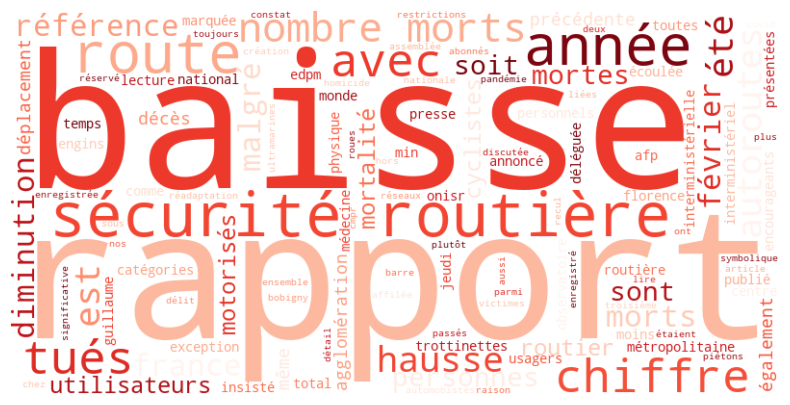

In [28]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

ARTICLE_PATH = Path("article.txt")

text = ARTICLE_PATH.read_text(encoding="utf-8")
tokens = re.findall(r"[A-Za-zÀ-ÖØ-öø-ÿ']+", text.lower())
stopwords = set("de la les un une des et en au aux du le que dans sur par pour les".split())
words = [w for w in tokens if w not in stopwords and len(w) > 2]

wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds")
image = wc.generate(" ".join(words))

plt.figure(figsize=(10, 5))
plt.imshow(image, interpolation="bilinear")
plt.axis("off")
plt.show()


Ce nuage de mots représente les termes les plus fréquents de l’article. On voit tout de suite que les mots dominants sont baisse, sécurité, routière, morts et rapport. Cela montre que l’article adopte une approche très factuelle et statistique de la sécurité routière, en insistant sur l’évolution des chiffres et des bilans officiels. La présence de mots comme année, chiffre ou nombre confirme que le discours est centré sur la mesure et la comparaison des données dans le temps. Enfin, le fait que les mots liés aux victimes soient très visibles souligne que la question de la mortalité reste au cœur du sujet, mais traitée principalement sous l’angle quantitatif plutôt que humain ou individuel.